# Mrbles Recon
Neerja Aggarwal

Mar 13th, 2024

Purpose: try to recon the mrbles bead data taken in Feb

In [1]:
# CHOOSE GPU
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('../')
gpu = 0

# ACTION: CHOOSE WHICH GPU TO USE (0-3)
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_LAUNCH_BLOCKING'] = str(1) # get more error messages
# ACTION: CHOOSE WHICH GPU TO USE (0-3)
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false' #stop jax from preallocating 75% of the gpu

# IMPORT ALL THE LIBRARIES
%run ../imports_util.py
import wandb_util as wb
import sdc_config5 as sdc

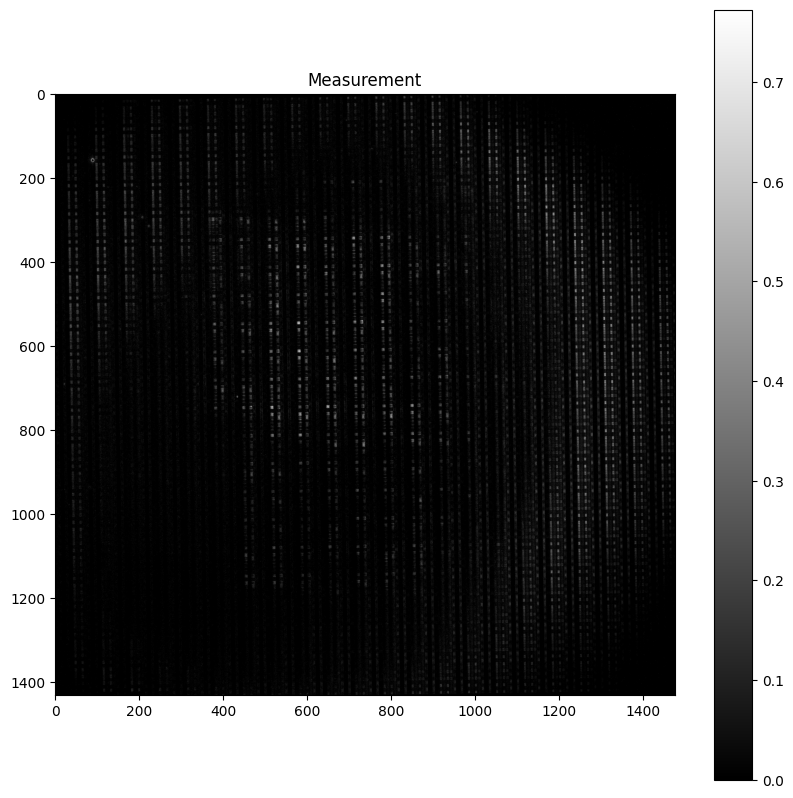

In [3]:
# TODO: CHANGE THE FOLLOWING VARIABLES AS NEEDED

calibration_location = '../'
psf_name = 'recon_materials_organized/psf_2024-01-30.pt'
filter_cube_file = 'Calibration_data/spectral_calibration_2024-02-23_8nmFWHM.pt'  # 'filter_stack'
# datafolder = '/media/azuldata/neerja/2024-02-01/mrbles_code1eu'
# meas_name = 'meas_20db.tiff'
# bg_name = 'bg_20db.tiff'

datafolder = '/media/azuldata/neerja/2024-02-01/mrbles_code3dy'
meas_name = 'meas.tiff'
bg_name = 'bg.tiff'

gt_name = 'gt.tiff'
ground_truth_spectra_locs = ['/media/azuldata/neerja/2022-04-08/greenbeads_oldslide_emissionspectra.csv', 
                            '/media/azuldata/neerja/2022-04-08/redbeads_fresh_emissionspectra.csv']
bits = 16
crop_indices = [420,1852,1350,2826] #top bottom left default: [320,1652,1350,2726]
wvmin = 450
wvmax = 800
wvstep = 6
downsample_factor = 2
sample = datafolder.split('/')[-1]
kmax = 2000
step_size = 1e-1
thr = 6e-6 #3e-6 is ok
xytv = 1e-6 #1e-4 is big
lamtv = 2e-6 #2e-6 is ok
kprint = 100
dict_learn = False
power = 1

run_name = sample + meas_name + '_thr={}_xytv={}_lamtv={}_kmax={}_stepsize={}_downsample={}'.format(thr, xytv, lamtv, kmax, step_size, downsample_factor)

# load the measurement and display it to make sure your crop indices are correct

# Uncomment this line to load from a folder of measurements to average over
# sample_meas = torch.mean(sdc.tif_loader(os.path.join(datafolder,'measurements'))/2**bits,0)
# Uncomment this line to load from a single measurement 
sample_meas = sdc.importTiff(datafolder,meas_name)/2**bits
try:
    background = sdc.importTiff(datafolder,bg_name)/2**bits
except:
    print('No background image found, continuing without background subtraction')
    background = torch.zeros(sample_meas.shape)
measurement = sdc.cropci((sample_meas-background),crop_indices).clip(0,1)**power

sdc.bw_visualize(measurement, title = "Measurement", colorbar = True)

In [4]:
# Set up waits and biases run
wandb.init(
    # Set the project where this run will be logged
    project='HyperSpectralDiffuserScope', 
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=run_name,
    # Track hyperparameters and run metadata
    config={"wvmin": wvmin,
            "wvmax": wvmax,
            "wvstep": wvstep,
            "kmax": kmax,
            "step_size": step_size,
            "thr": thr,
            "xytv": xytv,
            "lamtv": lamtv,
            "kprint": kprint,
            "dict_learn": dict_learn,
            "downsample_factor": downsample_factor,
            "sample": sample,
            "gpu": gpu,
            "spectral_calibration": filter_cube_file,
            "psf": psf_name,
            "power": power}
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: neerja (wallerlab). Use `wandb login --relogin` to force relogin


In [5]:
# LOAD CALIBRATION AND SET UP THE TRAINING LOOP

# Load wavelength calibration and downsample to spectral resolution of filter cube
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)

# Load and crop filter cube
spectral_filter_data = torch.load(os.path.join(calibration_location,filter_cube_file),map_location='cpu')
filterstack = sdc.cropci(spectral_filter_data['filter_stack'], crop_indices)
wv = torch.Tensor(spectral_filter_data['wavelength'])
msum = sdc.sumFilterArray(filterstack,wv,wvmin,wvmax,wvstep)
spectral_filter = msum/torch.amax(msum)

# Load and crop PSF
sensor_psf = torch.load(os.path.join(calibration_location, psf_name),map_location='cpu')
ccrop = torchvision.transforms.CenterCrop(spectral_filter.shape[1:]) # center the psf
psf = ccrop(sensor_psf)
psf = psf.clip(0) # clip negative values to 0

# Load ground truth image
try:
    gt = sdc.importTiff(datafolder,gt_name)/2**bits
    gt = gt/torch.max(gt)
    gt = torchvision.transforms.functional.rotate(gt.unsqueeze(0),-90).squeeze()
except:
    print('No ground truth image found, continuing without ground truth')
    gt = torch.zeros(measurement.shape)

# Load ground truth spectra
legend = []
spectra = []
for loc in ground_truth_spectra_locs:
    gt_wv,gt_int = sdc.loadspectrum(loc)
    gt_int = np.interp(wavelengths,gt_wv,gt_int)
    gt_int = gt_int/np.max(gt_int)
    gt_int = torch.tensor(gt_int)
    spectra.append(gt_int)
    legend.append(loc.split('/')[-1].split('.')[0].split('_')[0])

# Downsample the data
if downsample_factor != 1:
    spectral_filter = F.avg_pool2d(spectral_filter.unsqueeze(0), downsample_factor).squeeze()
    psf = F.avg_pool2d(psf.unsqueeze(0).unsqueeze(0), downsample_factor).squeeze()
    measurement = F.avg_pool2d(measurement.unsqueeze(0).unsqueeze(0), downsample_factor).squeeze()
psf = psf/torch.sum(psf) # l1 normalize the psf

# initialize the reconstruction
hpad = jnp.asarray(sdc.pad(psf))
hfftpad = jnp.fft.fft2(hpad)[None, ...]
m = jnp.asarray(spectral_filter)
meas = jnp.asarray(measurement)

padding = ((0,0,0),(np.ceil(m.shape[1]/2).astype(int),np.floor(m.shape[1]/2).astype(int),0),(np.ceil(m.shape[2]/2).astype(int),np.floor(m.shape[2]/2).astype(int),0))
# calculate the adjoint
xk = sdc.jax_adjoint_model(meas, m, hfftpad, padding)
# xk = jnp.zeros_like(xk)+1

# define the optimizer
optimizer = optax.adam(learning_rate=step_size)

# Initialize optimizer state
opt_state = optimizer.init(xk)

# define a function to calculate the gradient and return the loss
loss_and_grad = jax.jit(jax.value_and_grad(sdc.loss_func, (0)))

806


In [6]:
# run a training loop with a progress bar
for k in range(kmax):
    wandb_log = {}
    if k == 0:
        wandb_log = wb.wandb_log_meas(wandb_log, meas)
        wandb_log = wb.wandb_log_psf(wandb_log, psf)
        wandb_log = wb.wandb_log_ground_truth(wandb_log, gt)
            # calculate the loss and the gradient
    loss, grad = loss_and_grad(xk, meas, m, hfftpad, thr, xytv, lamtv)

    # log the mse of the measurement and simulated measurement
    wandb_log['data_loss'] = jnp.linalg.norm((sdc.jax_forward_model(xk, m, hfftpad) - meas).ravel(),2)**2

    # log the custom loss
    wandb_log['loss'] = loss

    # update the parameters
    updates, opt_state = optimizer.update(grad, opt_state)
    # replace nan values with 0
    updates = jnp.nan_to_num(updates)
    # break
    xk = optax.apply_updates(xk, updates)
    xk = jnp.clip(xk, 0, None)
    
    if k % kprint == 0:
        wandb_log = wb.wandb_log_sim_meas(wandb_log, sdc.jax_forward_model(xk, m, hfftpad))
        wandb_log = wb.wandb_log_false_color_recon(wandb_log, xk/jnp.max(xk)*jnp.sum(xk,0)[None,...], wavelengths)
        # save xk
        np.save(os.path.join('../Results', run_name+'.npy'), xk)
    
    wandb.log(wandb_log)

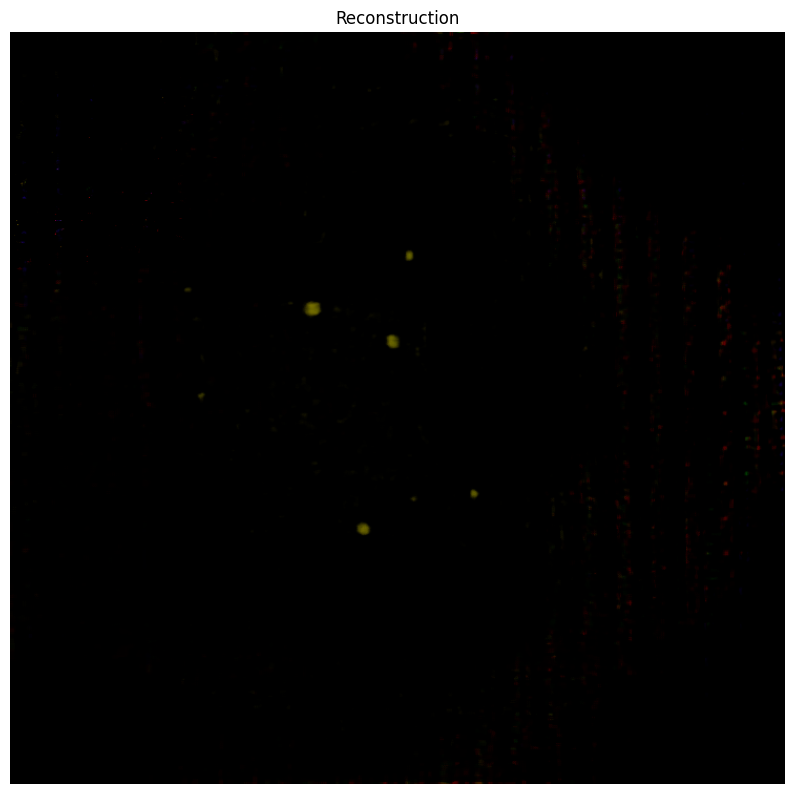

In [7]:
sdc.color_visualize( xk/jnp.max(xk)*jnp.sum(xk,0),wavelengths, title = "Reconstruction")

Text(0.5, 1.0, 'Reconstruction')

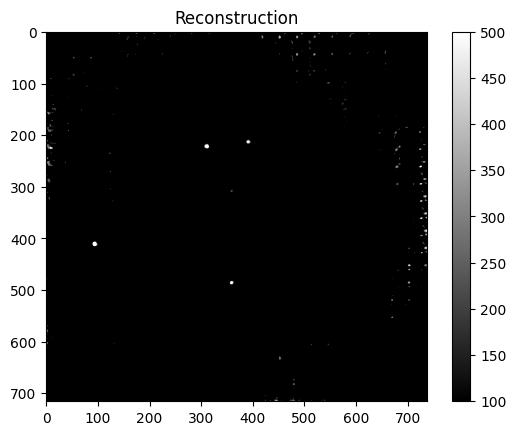

In [12]:
plt.imshow(jnp.sum(xk,0),cmap = 'gray')
plt.colorbar()
plt.clim([100, 500]) 
plt.title('Reconstruction')